In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import geopandas as gpd
import os
import shapely
from shapely.geometry import LineString, Point
from shapely.ops import cascaded_union
import numpy as np
import time
from sklearn.preprocessing import normalize
from numpy import linalg
from util import *
import hickle as hkl 
import pdb

In [3]:
def group_and_map(filename):
    t = pd.read_csv(filename)
    t['count'] = 1
    count = t.groupby(['pu','do'])['count'].count()
    count = pd.DataFrame(count)
    count.columns = ['Count']
    count.reset_index(inplace = True)
    del t
    keep = count.groupby(['pu'])['Count'].sum()
    keep = list(keep[keep/keep.sum() > 1e-4].index)
    count = count[count.pu.apply(lambda x: x in keep) * count.do.apply(lambda x: x in keep)]
    count.reset_index(inplace = True, drop = True)
    unique = count.pu.unique()
    statemap = dict(zip(unique, range(len(unique))))
    return count, statemap

def build_matrix(count, statemap):
    A = np.zeros((len(statemap),len(statemap)))
    for i in range(count.shape[0]):
        try:
            A[int(statemap[count.pu[i]]), int(statemap[count.do[i]])] = count.Count[i]
        except Exception as e:
            raise ValueError(e)
    A = normalize(A, norm = 'l1',axis = 1)
    assert all(np.isclose(linalg.norm(A, ord = 1,axis = 1), np.ones(A.shape[0])))
    return A

def inspect(A):
    plt.hist(A.sum(axis = 0), bins = 15,range = (0,15))
    plt.show()
    plt.hist(A.sum(axis = 1), bins = 15,range = (0,15))
    plt.show()

def get_center(grid):
    grid.geometry = grid.geometry.apply(lambda x: x.centroid)
    return grid

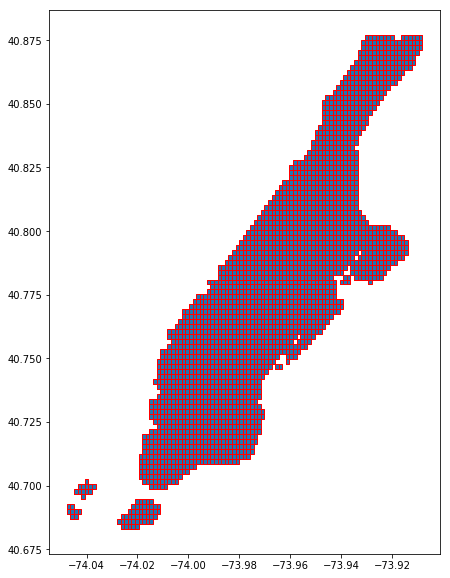

In [4]:
man = get_zones()
grid = get_joint_grid(man, 100, True)
grid = get_center(grid)

In [5]:
count,statemap = group_and_map('100.csv')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


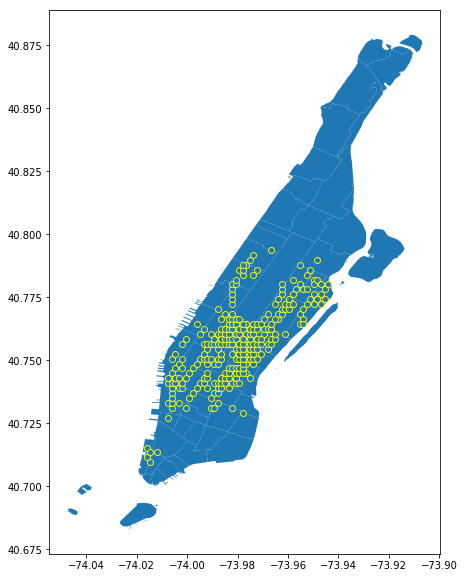

In [6]:
zone = gpd.read_file(r'taxi_zones\taxi_zones.shp')
zone = zone.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
man= zone[zone.borough == 'Manhattan']
fig, ax = plt.subplots(figsize = (10,10))
man.plot(ax=ax)
grid.loc[list(set(count[count.Count > 200].pu)),].plot(**{'edgecolor': 'yellow', 'alpha':0.9}, ax = ax)

In [7]:
A = build_matrix(count,statemap)

In [13]:
print(A.shape)
print(len(count))
hkl.dump(A, '100_matrix.hkl' )

(1093, 1093)
890134


### Decomposition

In [8]:
import numpy as np
from sklearn.decomposition import nmf
#import nmf_new
from sklearn.preprocessing import normalize
from numpy import linalg, random
from numpy.linalg import norm
from util import *
from nmf_adaptive import *

In [16]:
LAMBDA = 1e-10
EPS = 1e-14
GAMMA1 = 1.1
GAMMA2 = 1.2
LR = 100
d = A.shape[0]
r = 5
s0 = 1
U,V,mu,E = non_negative_factorization(A,s0,lr = LR, max_iter = 7, lambda_ = LAMBDA, eps = EPS, gamma1 = GAMMA1, gamma2 = GAMMA2)

[   INFO] - SUB - Starting error 0.0009389757707253839
[   INFO] - SUB - Iter 1: Error 0.0007784462375970065, Max Norm: 33.06055050963308, Mean Norm: 33.06055050963308, Min Norm of U: 33.06055050963308
[   INFO] - SUB - Iter 2: Error 0.0007735092388268661, Max Norm: 33.06055050963308, Mean Norm: 33.06055050963308, Min Norm of U: 33.06055050963308
[   INFO] - SUB - Iter 3: Error 0.0007733713278302618, Max Norm: 33.06055050963308, Mean Norm: 33.06055050963308, Min Norm of U: 33.06055050963308
[   INFO] - SUB - Iter 4: Error 0.0007733674478272726, Max Norm: 33.06055050963308, Mean Norm: 33.06055050963308, Min Norm of U: 33.06055050963308
[   INFO] - SUB - Iter 5: Error 0.000773367332077951, Max Norm: 33.06055050963308, Mean Norm: 33.06055050963308, Min Norm of U: 33.06055050963308
[   INFO] - SUB - Iter 6: Error 0.0007733673275385195, Max Norm: 33.06055050963308, Mean Norm: 33.06055050963308, Min Norm of U: 33.06055050963308
[   INFO] - SUB - Iter 7: Error 0.0007733673271918124, Max Norm:

[   INFO] - SUB - Iter 42: Error 0.0007477643913417591, Max Norm: 32.56168453223351, Mean Norm: 17.14437345913304, Min Norm of U: 1.72706238603257
[   INFO] - SUB - Iter 43: Error 0.0007476910343619217, Max Norm: 32.56168453223313, Mean Norm: 17.144373459133437, Min Norm of U: 1.7270623860337413
[   INFO] - SUB - Iter 44: Error 0.0007476189640033605, Max Norm: 32.56168453223273, Mean Norm: 17.14437345913382, Min Norm of U: 1.7270623860349081
[   INFO] - SUB - Iter 45: Error 0.0007475481113418454, Max Norm: 32.56168453223234, Mean Norm: 17.144373459134208, Min Norm of U: 1.727062386036073
[   INFO] - SUB - Iter 46: Error 0.0007474784741128697, Max Norm: 32.561684532231965, Mean Norm: 17.1443734591346, Min Norm of U: 1.727062386037235
[   INFO] - SUB - Iter 47: Error 0.0007474100646364683, Max Norm: 32.56168453223157, Mean Norm: 17.144373459134982, Min Norm of U: 1.7270623860383951
[   INFO] - SUB - Iter 48: Error 0.0007473428010690982, Max Norm: 32.561684532231176, Mean Norm: 17.1443734

[   INFO] - SUB - Iter 97: Error 0.0007451550105981483, Max Norm: 32.56168453221137, Mean Norm: 17.144373459151534, Min Norm of U: 1.7270623860916923
[   INFO] - SUB - Iter 98: Error 0.000745127356156958, Max Norm: 32.56168453221094, Mean Norm: 17.144373459151797, Min Norm of U: 1.7270623860926535
[   INFO] - SUB - Iter 99: Error 0.0007451002179435034, Max Norm: 32.56168453221053, Mean Norm: 17.14437345915207, Min Norm of U: 1.7270623860936105
[   INFO] - SUB - Iter 100: Error 0.0007450735573863034, Max Norm: 32.5616845322101, Mean Norm: 17.144373459152334, Min Norm of U: 1.7270623860945638
[   INFO] - SUB - Iter 101: Error 0.0007450473748134715, Max Norm: 32.56168453220969, Mean Norm: 17.1443734591526, Min Norm of U: 1.7270623860955125
[   INFO] - SUB - Iter 102: Error 0.0007450216590417987, Max Norm: 32.56168453220927, Mean Norm: 17.144373459152863, Min Norm of U: 1.727062386096457
[   INFO] - SUB - Iter 103: Error 0.0007449963732304995, Max Norm: 32.56168453220886, Mean Norm: 17.144

[   INFO] - SUB - Iter 14: Error 0.0007433173463797184, Max Norm: 32.25117618874683, Mean Norm: 11.540524772380884, Min Norm of U: 0.7495832918893648
[   INFO] - SUB - Iter 15: Error 0.0007432606824955235, Max Norm: 32.251176188746435, Mean Norm: 11.540524772380964, Min Norm of U: 0.7495832918889631
[   INFO] - SUB - Iter 16: Error 0.0007432045528345449, Max Norm: 32.25117618874603, Mean Norm: 11.540524772381048, Min Norm of U: 0.749583291888571
[   INFO] - SUB - Iter 17: Error 0.0007431489769871201, Max Norm: 32.25117618874563, Mean Norm: 11.540524772381133, Min Norm of U: 0.7495832918881877
[   INFO] - SUB - Iter 18: Error 0.0007430940401536495, Max Norm: 32.251176188745234, Mean Norm: 11.54052477238122, Min Norm of U: 0.7495832918878147
[   INFO] - SUB - Iter 19: Error 0.0007430396758130688, Max Norm: 32.25117618874483, Mean Norm: 11.540524772381303, Min Norm of U: 0.74958329188745
[   INFO] - SUB - Iter 20: Error 0.0007429857370380733, Max Norm: 32.25117618874442, Mean Norm: 11.540

[   INFO] - SUB - Iter 69: Error 0.0007408136433847095, Max Norm: 32.25117618872313, Mean Norm: 11.540524772386043, Min Norm of U: 0.7495832918797932
[   INFO] - SUB - Iter 70: Error 0.0007407767517016081, Max Norm: 32.251176188722674, Mean Norm: 11.540524772386147, Min Norm of U: 0.7495832918798303
[   INFO] - SUB - Iter 71: Error 0.0007407401964238647, Max Norm: 32.25117618872223, Mean Norm: 11.540524772386258, Min Norm of U: 0.7495832918798739
[   INFO] - SUB - Iter 72: Error 0.0007407039089518539, Max Norm: 32.25117618872176, Mean Norm: 11.54052477238636, Min Norm of U: 0.7495832918799237
[   INFO] - SUB - Iter 73: Error 0.0007406679411448971, Max Norm: 32.25117618872132, Mean Norm: 11.54052477238647, Min Norm of U: 0.7495832918799806
[   INFO] - SUB - Iter 74: Error 0.0007406322226673196, Max Norm: 32.25117618872085, Mean Norm: 11.540524772386576, Min Norm of U: 0.7495832918800436
[   INFO] - SUB - Iter 75: Error 0.0007405967341164319, Max Norm: 32.25117618872039, Mean Norm: 11.54

[   INFO] - SUB - Iter 124: Error 0.0007391004142512144, Max Norm: 32.25117618869642, Mean Norm: 11.540524772391395, Min Norm of U: 0.7495832918882125
[   INFO] - SUB - Iter 125: Error 0.0007390742231505188, Max Norm: 32.251176188695894, Mean Norm: 11.540524772391487, Min Norm of U: 0.7495832918884943
[   INFO] - SUB - Iter 126: Error 0.0007390482193577425, Max Norm: 32.2511761886954, Mean Norm: 11.540524772391594, Min Norm of U: 0.7495832918887799
[   INFO] - SUB - Iter 127: Error 0.0007390223673164538, Max Norm: 32.251176188694885, Mean Norm: 11.540524772391691, Min Norm of U: 0.7495832918890706
[   INFO] - SUB - Iter 128: Error 0.0007389966873255948, Max Norm: 32.251176188694366, Mean Norm: 11.540524772391786, Min Norm of U: 0.7495832918893651
[   INFO] - SUB - Iter 129: Error 0.0007389711510607053, Max Norm: 32.251176188693854, Mean Norm: 11.540524772391885, Min Norm of U: 0.7495832918896641
[   INFO] - SUB - Iter 130: Error 0.0007389457409810586, Max Norm: 32.25117618869333, Mean 

[   INFO] - SUB - Iter 179: Error 0.000737883409886335, Max Norm: 32.251176188667046, Mean Norm: 11.540524772396871, Min Norm of U: 0.7495832919092118
[   INFO] - SUB - Iter 180: Error 0.000737864957823938, Max Norm: 32.2511761886665, Mean Norm: 11.540524772396978, Min Norm of U: 0.7495832919096842
[   INFO] - SUB - Iter 181: Error 0.0007378466003173553, Max Norm: 32.25117618866596, Mean Norm: 11.540524772397085, Min Norm of U: 0.74958329191016
[   INFO] - SUB - Iter 182: Error 0.0007378283485595244, Max Norm: 32.25117618866538, Mean Norm: 11.540524772397179, Min Norm of U: 0.7495832919106377
[   INFO] - SUB - Iter 183: Error 0.0007378102066773203, Max Norm: 32.251176188664836, Mean Norm: 11.540524772397283, Min Norm of U: 0.7495832919111185
[   INFO] - SUB - Iter 184: Error 0.0007377921410183733, Max Norm: 32.25117618866426, Mean Norm: 11.540524772397378, Min Norm of U: 0.7495832919116013
[   INFO] - SUB - Iter 185: Error 0.0007377741586126043, Max Norm: 32.25117618866371, Mean Norm: 

[   INFO] - SUB - Iter 32: Error 0.0007224311033242561, Max Norm: 31.72864343536963, Mean Norm: 8.828273949802186, Min Norm of U: 0.6826269103925686
[   INFO] - SUB - Iter 33: Error 0.0007223011779254848, Max Norm: 31.728643435369044, Mean Norm: 8.828273949802279, Min Norm of U: 0.6826269103926909
[   INFO] - SUB - Iter 34: Error 0.0007221771167054387, Max Norm: 31.728643435368475, Mean Norm: 8.828273949802375, Min Norm of U: 0.6826269103928088
[   INFO] - SUB - Iter 35: Error 0.0007220583514346813, Max Norm: 31.728643435367886, Mean Norm: 8.828273949802469, Min Norm of U: 0.6826269103929203
[   INFO] - SUB - Iter 36: Error 0.0007219447998613414, Max Norm: 31.7286434353673, Mean Norm: 8.828273949802561, Min Norm of U: 0.6826269103930277
[   INFO] - SUB - Iter 37: Error 0.0007218364093583659, Max Norm: 31.728643435366745, Mean Norm: 8.828273949802663, Min Norm of U: 0.6826269103931302
[   INFO] - SUB - Iter 38: Error 0.000721732606965044, Max Norm: 31.72864343536614, Mean Norm: 8.828273

[   INFO] - SUB - Iter 87: Error 0.0007196372347790555, Max Norm: 31.72864343533782, Mean Norm: 8.828273949806338, Min Norm of U: 0.6826269103951145
[   INFO] - SUB - Iter 88: Error 0.0007196232054956832, Max Norm: 31.728643435337236, Mean Norm: 8.82827394980638, Min Norm of U: 0.682626910395127
[   INFO] - SUB - Iter 89: Error 0.0007196096394013529, Max Norm: 31.72864343533667, Mean Norm: 8.828273949806427, Min Norm of U: 0.6826269103951391
[   INFO] - SUB - Iter 90: Error 0.0007195965180776901, Max Norm: 31.72864343533611, Mean Norm: 8.828273949806475, Min Norm of U: 0.6826269103951516
[   INFO] - SUB - Iter 91: Error 0.0007195838214725496, Max Norm: 31.72864343533552, Mean Norm: 8.828273949806514, Min Norm of U: 0.6826269103951632
[   INFO] - SUB - Converged after 90 iterations
[   INFO] - Initial sigma: 0.00014692487498168806
[   INFO] - Escaped: Iter_ 200, Sigma = 0.0004605920743965087, Smaller than lambda: False
[   INFO] - MAIN - Choose kappa = 3.3477140706728816, p = 1
[   INFO

[   INFO] - SUB - Iter 49: Error 0.0007021473376703979, Max Norm: 29.918521857183585, Mean Norm: 7.266203303136246, Min Norm of U: 0.5795746690486149
[   INFO] - SUB - Iter 50: Error 0.0007020949899993112, Max Norm: 29.91852185718287, Mean Norm: 7.2662033031363125, Min Norm of U: 0.5795746690487564
[   INFO] - SUB - Iter 51: Error 0.0007020444896571463, Max Norm: 29.91852185718218, Mean Norm: 7.266203303136386, Min Norm of U: 0.5795746690488986
[   INFO] - SUB - Iter 52: Error 0.0007019955529251386, Max Norm: 29.9185218571815, Mean Norm: 7.26620330313646, Min Norm of U: 0.5795746690490413
[   INFO] - SUB - Iter 53: Error 0.0007019481348500005, Max Norm: 29.91852185718081, Mean Norm: 7.266203303136531, Min Norm of U: 0.5795746690491833
[   INFO] - SUB - Iter 54: Error 0.0007019021312364504, Max Norm: 29.91852185718013, Mean Norm: 7.266203303136605, Min Norm of U: 0.5795746690493268
[   INFO] - SUB - Iter 55: Error 0.0007018574720355509, Max Norm: 29.91852185717945, Mean Norm: 7.26620330

[   INFO] - SUB - Iter 2: Error 0.0006953098297526223, Max Norm: 27.598095722240526, Mean Norm: 6.192841868835214, Min Norm of U: 0.4694749118198885
[   INFO] - SUB - Iter 3: Error 0.0006949020532862189, Max Norm: 27.598095722239872, Mean Norm: 6.192841868835296, Min Norm of U: 0.46947491182031575
[   INFO] - SUB - Iter 4: Error 0.0006945265863623374, Max Norm: 27.59809572223921, Mean Norm: 6.1928418688353775, Min Norm of U: 0.4694749118207395
[   INFO] - SUB - Iter 5: Error 0.0006941789882531113, Max Norm: 27.59809572223852, Mean Norm: 6.192841868835454, Min Norm of U: 0.4694749118211602
[   INFO] - SUB - Iter 6: Error 0.0006938541409001837, Max Norm: 27.598095722237865, Mean Norm: 6.1928418688355364, Min Norm of U: 0.4694749118215783
[   INFO] - SUB - Iter 7: Error 0.0006935509062887411, Max Norm: 27.598095722237197, Mean Norm: 6.192841868835617, Min Norm of U: 0.46947491182199463
[   INFO] - SUB - Iter 8: Error 0.0006932686585797635, Max Norm: 27.598095722236533, Mean Norm: 6.192841

[   INFO] - SUB - Iter 57: Error 0.0006884908543987445, Max Norm: 27.59809572220423, Mean Norm: 6.192841868839332, Min Norm of U: 0.46947491184252754
[   INFO] - SUB - Iter 58: Error 0.0006884539843204571, Max Norm: 27.59809572220359, Mean Norm: 6.192841868839402, Min Norm of U: 0.4694749118429526
[   INFO] - SUB - Iter 59: Error 0.0006884179875373168, Max Norm: 27.59809572220293, Mean Norm: 6.19284186883947, Min Norm of U: 0.46947491184337764
[   INFO] - SUB - Iter 60: Error 0.000688382794208389, Max Norm: 27.598095722202295, Mean Norm: 6.192841868839543, Min Norm of U: 0.46947491184380435
[   INFO] - SUB - Iter 61: Error 0.0006883483489199791, Max Norm: 27.598095722201634, Mean Norm: 6.1928418688396105, Min Norm of U: 0.46947491184423157
[   INFO] - SUB - Iter 62: Error 0.0006883146385531151, Max Norm: 27.598095722200988, Mean Norm: 6.192841868839679, Min Norm of U: 0.46947491184465995
[   INFO] - SUB - Iter 63: Error 0.0006882816025097769, Max Norm: 27.598095722200338, Mean Norm: 6.

[   INFO] - SUB - Converged after 110 iterations
[   INFO] - Initial sigma: 0.0001917931482413123
[   INFO] - Escaped: Iter_ 200, Sigma = 0.00036166562260621143, Smaller than lambda: False
[   INFO] - MAIN - Achieve global optimum by kappa = 5.4397844670137885e-09!


In [17]:
U.shape

(1093, 6)

In [18]:
hkl.dump(U, '100_matrix_U.hkl' )

### Clustering

In [19]:
from sklearn.cluster import KMeans
pred = KMeans(n_clusters=10).fit_predict(U)

In [20]:
inv_statemap = {v:k for k,v in statemap.items()}

In [21]:
mapped_result = []
for group in range(10):
    mapped_result.append([inv_statemap[mem] for mem in list(np.where(pred == group)[0])])

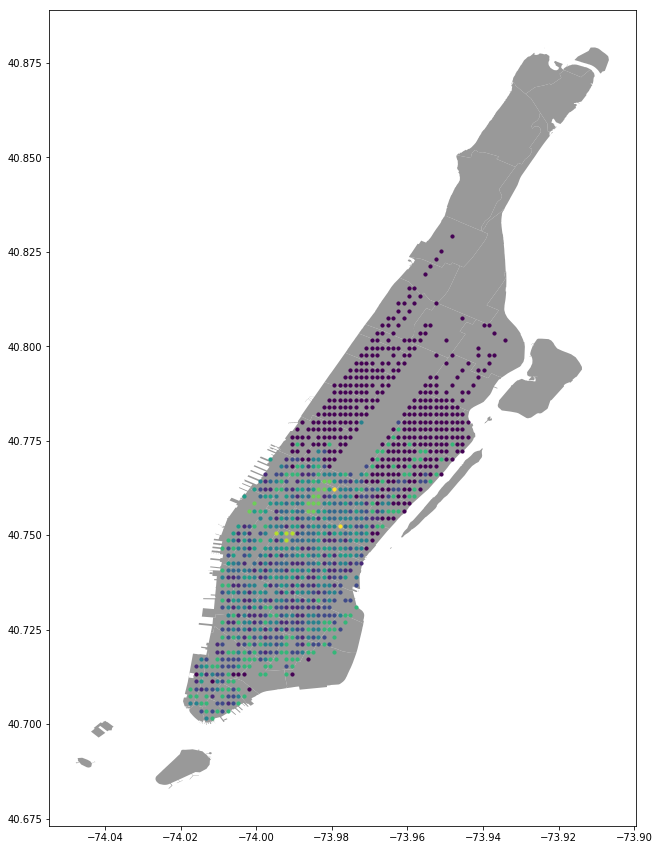

In [22]:
zone = gpd.read_file(r'taxi_zones\taxi_zones.shp')
zone = zone.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
man= zone[zone.borough == 'Manhattan']
fig, ax = plt.subplots(figsize = (15,15))
man.plot(ax=ax, color = 'grey', alpha = 0.8)
mapped = mapped_result[0:10]
ColorsA=plt.cm.viridis(np.linspace(0, 1,len(mapped)),alpha=10)
for i,group in enumerate(mapped):
    grid.iloc[group,].plot(**{'color': ColorsA[i], 'markersize':10}, ax = ax)